In [1]:
# import system libs
import os
import time
import random
import pathlib
import itertools
from glob import glob

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

# import Deep learning Libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, SeparableConv2D, GroupNormalization

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [2]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [3]:
def create_gens(df, aug_dict, preprocessing_steps=[]):
    img_size = (256, 256)
    batch_size = 40

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    image_gen = img_gen.flow_from_dataframe(df, x_col='images_paths', class_mode=None, color_mode='rgb', 
                                            target_size=img_size, batch_size=batch_size, seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='masks_paths', class_mode=None, color_mode='grayscale', 
                                           target_size=img_size, batch_size=batch_size, seed=1)

    gen = zip(image_gen, mask_gen)

    for img, msk in gen:
        img = img / 255.0  # Normalize image to [0, 1]
        msk = msk / 255.0  # Normalize mask to [0, 1]
        msk[msk > 0.5] = 1  # Binarize mask
        msk[msk <= 0.5] = 0  

        # Apply preprocessing steps to each image in batch
        for step in preprocessing_steps:
            img, msk = step(img, msk)

        yield (img, msk)


In [4]:
# Z-score normalization
def z_score_norm(img, msk, mean=0.5, std=0.2): 
    img = (img - mean) / std  
    return img, msk

# Histogram Equalization (for contrast enhancement)
def hist_eq(img, msk):
    img_new = np.zeros_like(img)
    for i in range(img.shape[0]):  # Loop through batch
        img_yuv = cv2.cvtColor((img[i] * 255).astype(np.uint8), cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])  # Apply to Y channel
        img_new[i] = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB) / 255.0
    return img_new, msk


# Gaussian Blur (for noise reduction)
def gaussian_blur(img, msk, kernel_size=(5,5)):
    img = np.array([cv2.GaussianBlur(i, kernel_size, 0) for i in img])
    return img, msk


In [5]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder Path
    conv1 = SeparableConv2D(64, (3, 3), padding="same")(inputs)
    conv1 = Activation("relu")(conv1)
    conv1 = SeparableConv2D(64, (3, 3), padding="same")(conv1)
    conv1 = GroupNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = SeparableConv2D(128, (3, 3), padding="same")(pool1)
    conv2 = Activation("relu")(conv2)
    conv2 = SeparableConv2D(128, (3, 3), padding="same")(conv2)
    conv2 = GroupNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = SeparableConv2D(256, (3, 3), padding="same")(pool2)
    conv3 = Activation("relu")(conv3)
    conv3 = SeparableConv2D(256, (3, 3), padding="same")(conv3)
    conv3 = GroupNormalization()(conv3)
    conv3 = Activation("relu")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = SeparableConv2D(512, (3, 3), padding="same")(pool3)
    conv4 = Activation("relu")(conv4)
    conv4 = SeparableConv2D(512, (3, 3), padding="same")(conv4)
    conv4 = GroupNormalization()(conv4)
    conv4 = Activation("relu")(conv4)

    # Decoder Path
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(conv4)
    up5 = concatenate([up5, conv3])
    conv5 = SeparableConv2D(256, (3, 3), padding="same")(up5)
    conv5 = Activation("relu")(conv5)
    conv5 = SeparableConv2D(256, (3, 3), padding="same")(conv5)
    conv5 = GroupNormalization()(conv5)
    conv5 = Activation("relu")(conv5)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv5)
    up6 = concatenate([up6, conv2])
    conv6 = SeparableConv2D(128, (3, 3), padding="same")(up6)
    conv6 = Activation("relu")(conv6)
    conv6 = SeparableConv2D(128, (3, 3), padding="same")(conv6)
    conv6 = GroupNormalization()(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv6)
    up7 = concatenate([up7, conv1])
    conv7 = SeparableConv2D(64, (3, 3), padding="same")(up7)
    conv7 = Activation("relu")(conv7)
    conv7 = SeparableConv2D(64, (3, 3), padding="same")(conv7)
    conv7 = GroupNormalization()(conv7)
    conv7 = Activation("relu")(conv7)

    outputs = SeparableConv2D(1, (1, 1), activation="sigmoid")(conv7)

    return Model(inputs, outputs)

In [6]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [7]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]
        # read image and convert it to RGB scale
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read mask
        mask = cv2.imread(mask_path)
        # sho image and mask
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4)

        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'

df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

print(len(train_df))

tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')


preprocessing_pipeline = [z_score_norm, hist_eq, gaussian_blur]

train_gen = create_gens(train_df, aug_dict=tr_aug_dict, preprocessing_steps=preprocessing_pipeline)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})

#show_images(list(train_df['images_paths']), list(train_df['masks_paths']))

3143


In [9]:
model = unet()

model.compile(optimizer=AdamW(learning_rate=0.001), loss=[dice_loss], metrics=['accuracy', dice_coef, iou_coef])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 256, 256, 64)   │            283 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ separable_conv2d[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 256, 256, 64)   │          4,736 │ activation[0][0]       │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization       │ (None, 256, 256, 64)   │            128 │ separable_conv2d_1[0]… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ group_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 128, 128, 128)  │          8,896 │ max_pooling2d[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ separable_conv2d_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 128, 128, 128)  │         17,664 │ activation_2[0][0]     │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_normalization_1     │ (None, 128, 128, 128)  │            256 │ separable_conv2d_3[0]… │
│ (GroupNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ group_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 64, 64, 256)    │         34,176 │ max_pooling2d_1[0][0]  │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 64, 64, 256)    │              0 │ separable_conv2d_4[0]… │
├──────────────────────

 Total params: 1,497,564 (5.71 MB)

 Trainable params: 1,497,564 (5.71 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs = 120
batch_size = 120

# Callbacks
callbacks = [
    ModelCheckpoint('unet.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
]

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=valid_gen,
    validation_steps=len(valid_df) // batch_size,
)


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7039 - dice_coef: 0.0211 - iou_coef: 0.0107 - loss: -0.0211Found 393 validated image filenames.
Found 393 validated image filenames.

Epoch 1: val_loss improved from inf to -0.01148, saving model to unet.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7030 - dice_coef: 0.0211 - iou_coef: 0.0107 - loss: -0.0211 - val_accuracy: 0.3499 - val_dice_coef: 0.0115 - val_iou_coef: 0.0058 - val_loss: -0.0115 - learning_rate: 0.0010
Epoch 2/120
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7057 - dice_coef: 0.0287 - iou_coef: 0.0146 - loss: -0.0287
Epoch 2: val_loss improved from -0.01148 to -0.03604, saving model to unet.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7071 - dice_coef: 0.0290 - iou_coef: 0.0147 - loss: -0.0290 - val_accuracy: 0.8898 - val_dice_coef: 0.0360 - val_iou_coef: 0.0184 - val_loss: -0.0360 - learning_rate

In [11]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train Dice: ", train_score[2])
print("Train IoU: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid Dice: ", valid_score[2])
print("Valid IoU: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test Dice: ", test_score[2])
print("Test IoU: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 847ms/step - accuracy: 0.9827 - dice_coef: 0.2941 - iou_coef: 0.1759 - loss: -0.2943
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 161ms/step - accuracy: 0.9925 - dice_coef: 0.5149 - iou_coef: 0.3551 - loss: -0.5152
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 24s 184ms/step - accuracy: 0.9929 - dice_coef: 0.4710 - iou_coef: 0.3182 - loss: -0.4712
Train Loss:  -0.2958834171295166
Train Accuracy:  0.9825805425643921
Train Dice:  0.29541879892349243
Train IoU:  0.17688363790512085
--------------------
Valid Loss:  -0.5176369547843933
Valid Accuracy:  0.9924997091293335
Valid Dice:  0.5174336433410645
Valid IoU:  0.35623931884765625
--------------------
Test Loss:  -0.46965858340263367
Test Accuracy:  0.9929319024085999
Test Dice:  0.4691218435764313
Test IoU:  0.31887587904930115


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


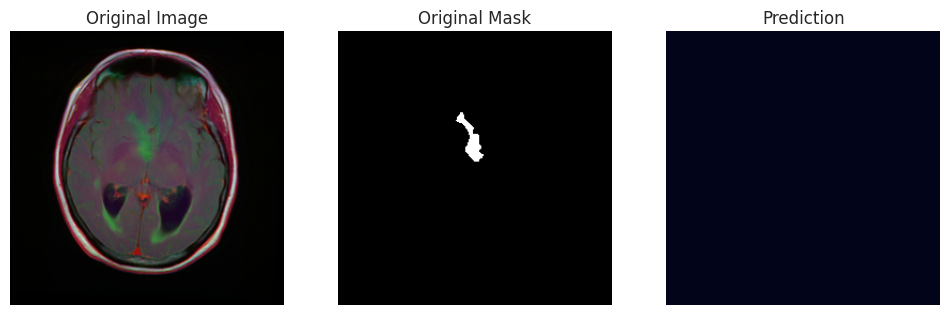

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


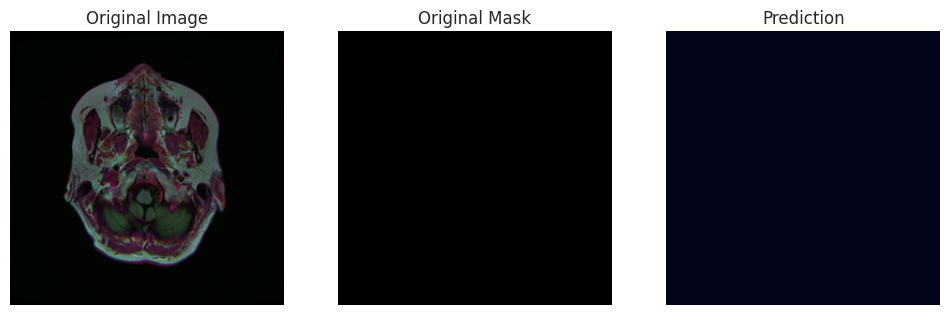

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


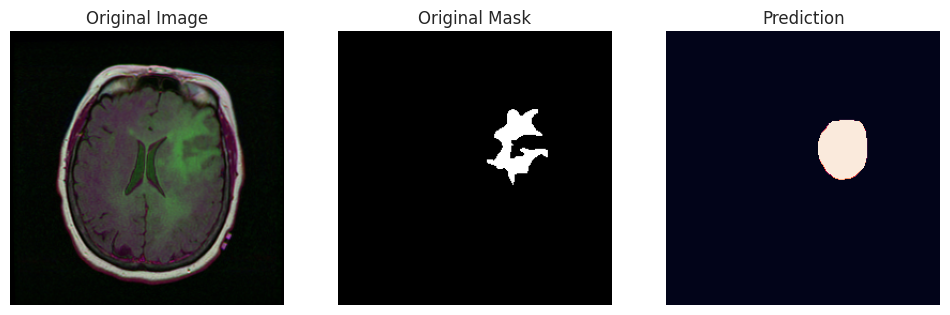

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


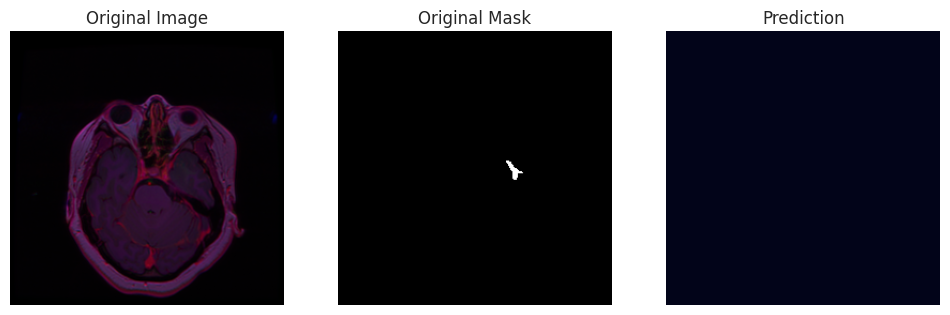

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


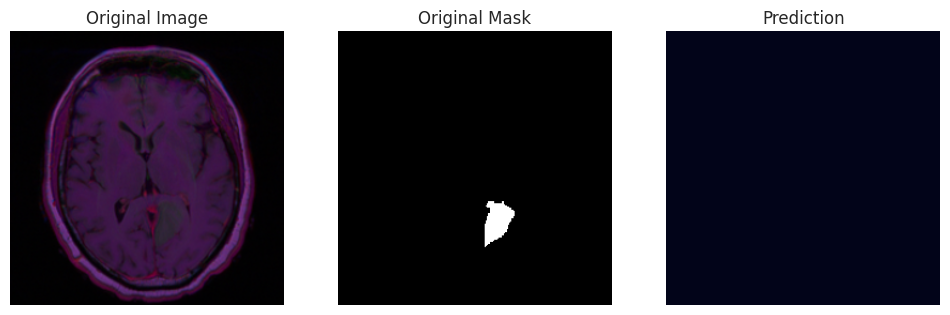

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


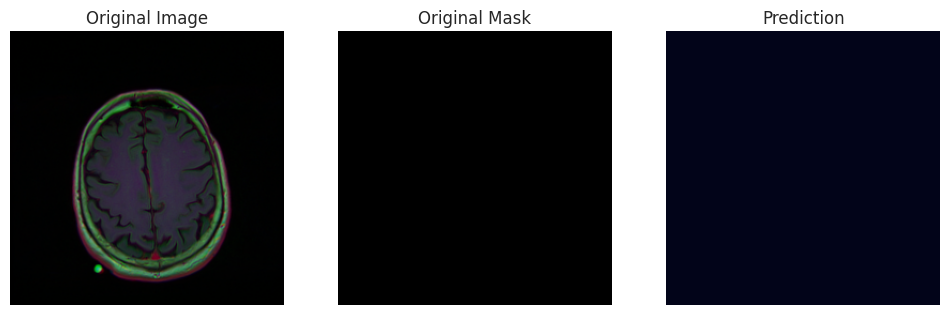

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


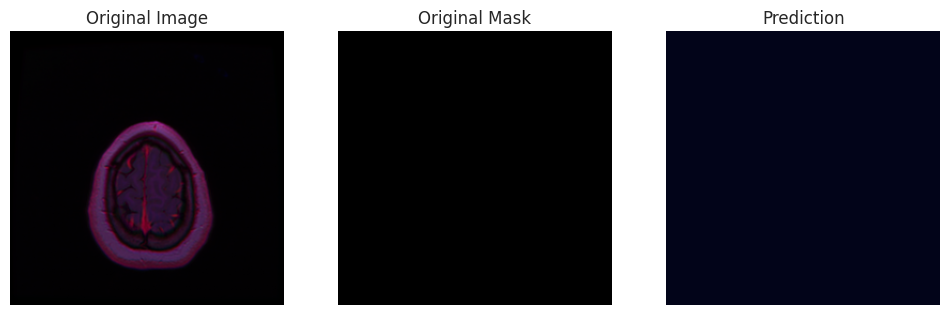

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


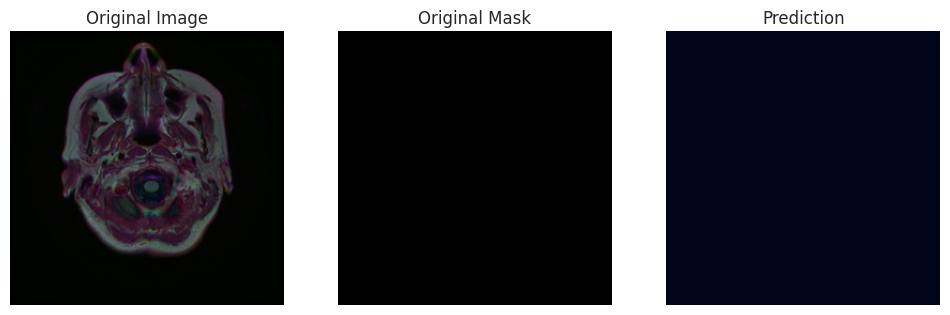

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


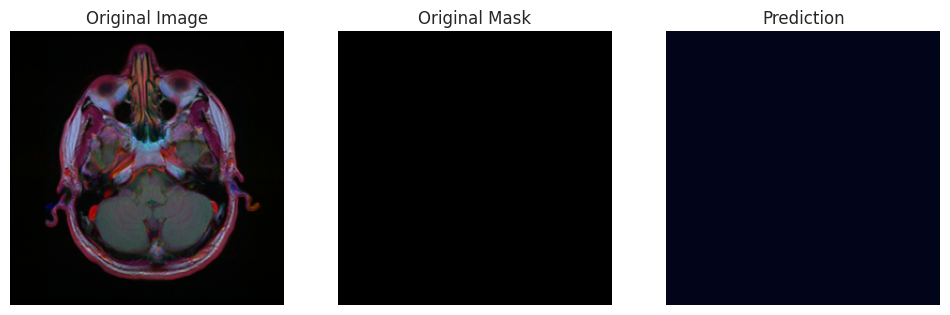

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


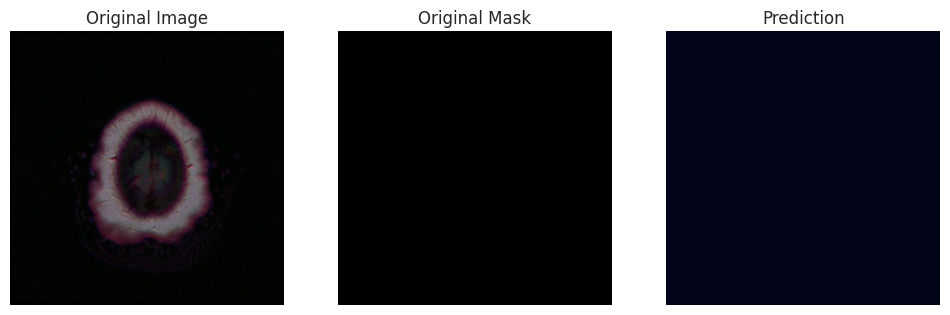

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


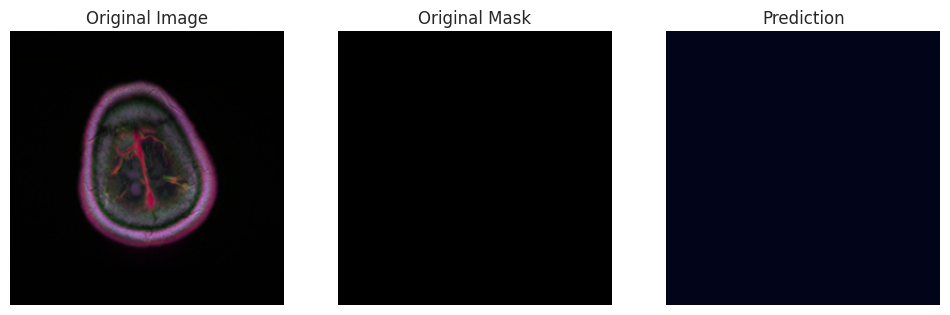

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


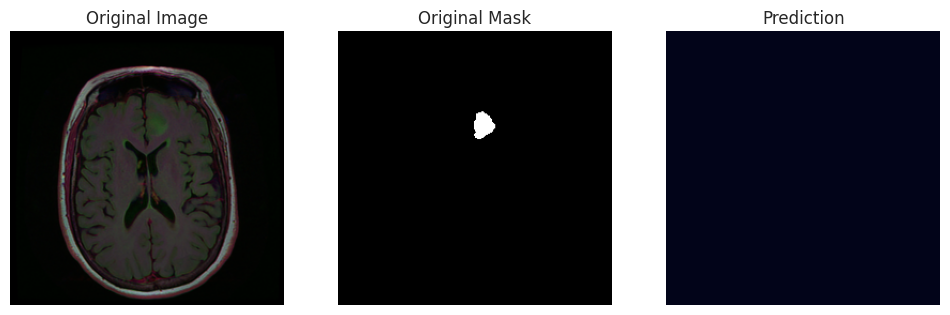

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


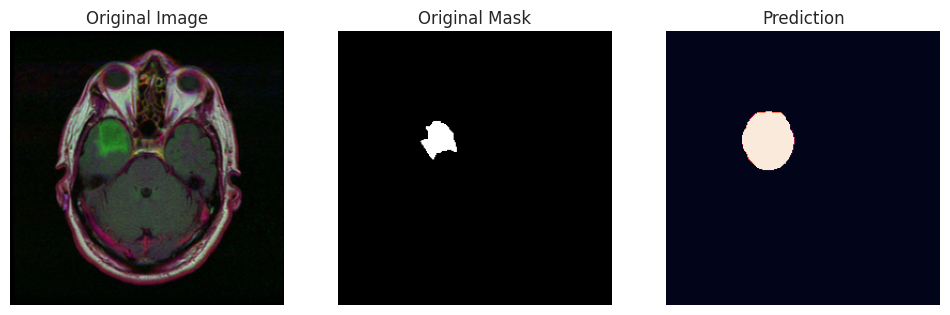

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


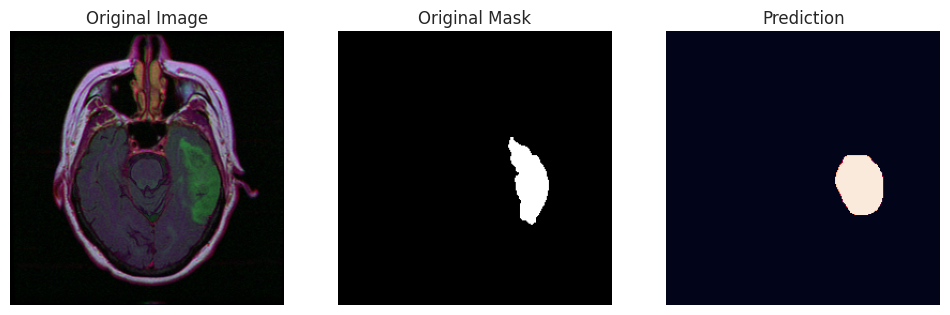

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


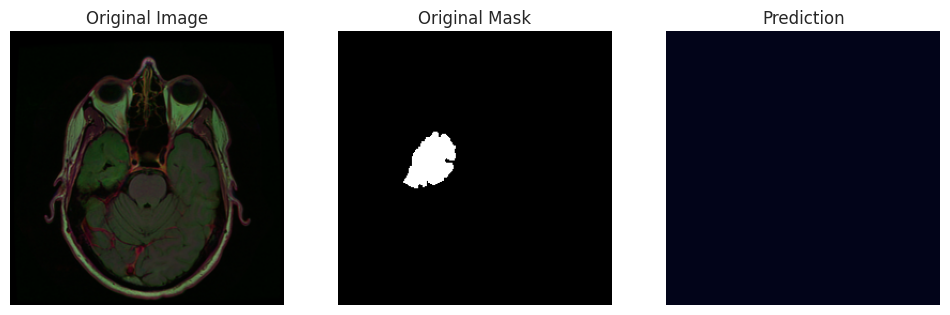

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


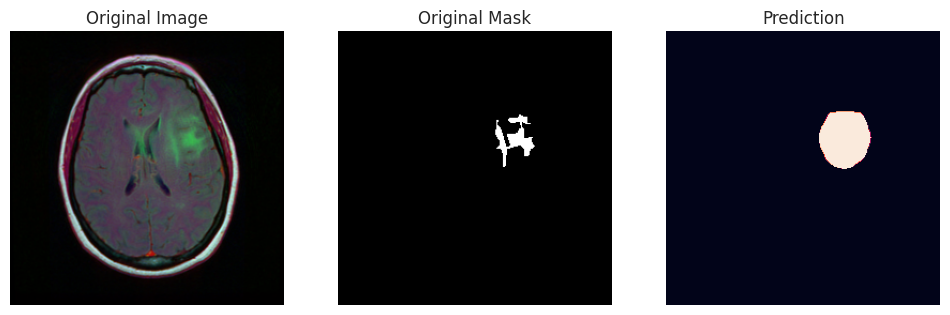

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


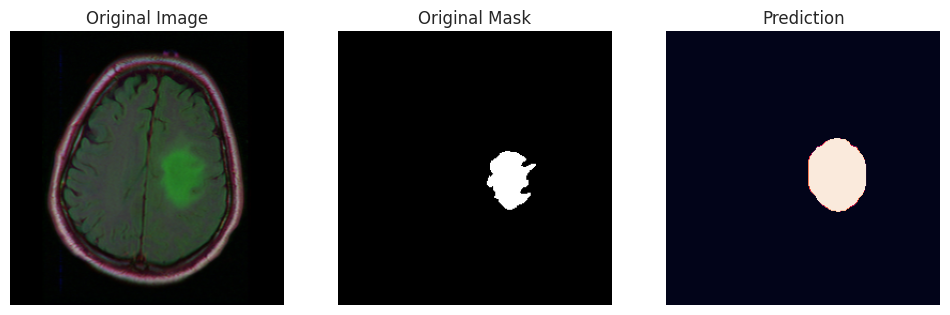

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


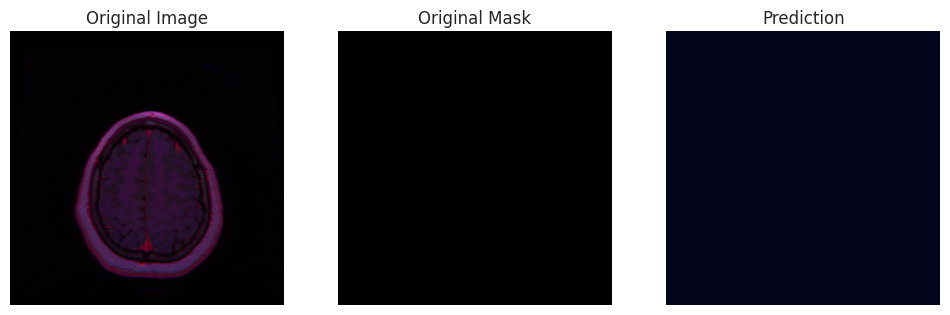

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


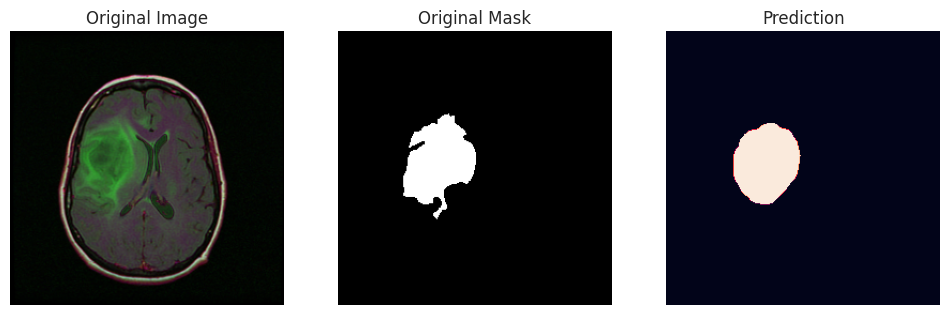

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


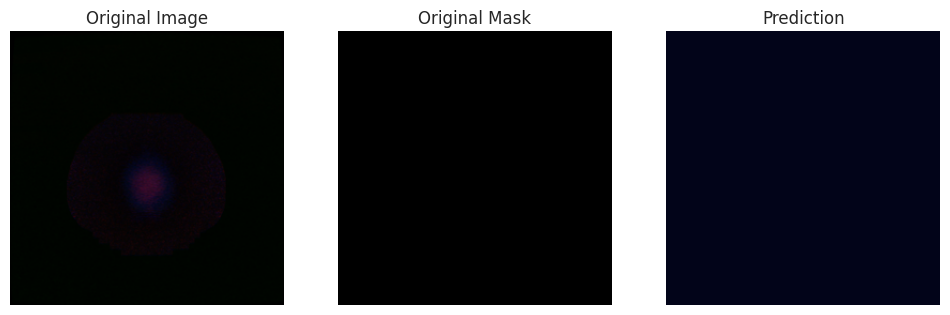

In [12]:
for _ in range(50):
    index = np.random.randint(1, len(test_df.head(2000).index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()